In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import math
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch.nn.functional as F

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
from sklearn.preprocessing import MinMaxScaler

## Setting

In [3]:
plt.rcParams['font.family']='Times New Roman'
plt.rc('font', size=30)     
plt.rc('axes', labelsize=35)
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30)
plt.rc('legend', fontsize=25)
#plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['axes.grid'] = True

### Please check the batch_size below (might be different based on the avaliability of each GPU)

In [4]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Number of training epochs
num_epochs = 500

# Learning rate for optimizers
lr = 0.0001#0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.8

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

## Load Data

In [5]:
adj_w = np.load('WS_lintransform_act_full.npy')
adj = np.load('adj_full.npy')

In [6]:
Temp = pd.read_csv('Temp_2016.csv')
Dew = pd.read_csv('dew_2016.csv')
Speed = pd.read_csv('speed_2016.csv')
Cloud = pd.read_csv('cloud_2016.csv')
Voltage = pd.read_csv('Voltage_2016_full.csv')

In [7]:
ws_df = pd.read_csv('weather_to_weather_connections.csv')

In [9]:
Temp

,K11R,K3T5,K6R6,KABI,KACT,KADS,KAFW,KALI,KAMA,KAQO,...,KT65,KT82,KTKI,KTPL,KTRL,KTYR,KUTS,KUVA,KVCT,KXBP
0,52.0,54.0,50.0,39.0,48.0,NaN,46.0,55.0,28.0,50.0,...,52.0,46.0,46.0,48.0,48.0,48.0,50.0,52.0,54.0,45.0
1,52.0,54.0,48.0,37.0,48.0,46.0,45.0,55.0,28.0,50.0,...,52.0,46.0,45.0,48.0,46.0,48.0,48.0,52.0,54.0,45.0
2,52.0,52.0,46.0,37.0,46.0,45.0,45.0,54.0,28.0,48.0,...,50.0,46.0,43.0,48.0,46.0,46.0,48.0,52.0,54.0,43.0
3,50.0,52.0,46.0,37.0,46.0,45.0,45.0,54.0,27.0,48.0,...,50.0,46.0,43.0,48.0,45.0,46.0,48.0,52.0,54.0,43.0
4,48.0,50.0,46.0,37.0,46.0,45.0,43.0,54.0,27.0,48.0,...,50.0,46.0,43.0,46.0,45.0,45.0,46.0,50.0,52.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,64.0,61.0,72.0,70.0,72.0,64.0,68.0,64.0,43.0,NaN,...,68.0,68.0,64.0,70.0,66.0,66.0,64.0,63.0,61.0,68.0
8780,64.0,63.0,73.0,70.0,72.0,NaN,72.0,68.0,45.0,NaN,...,70.0,70.0,66.0,75.0,70.0,70.0,64.0,66.0,63.0,68.0
8781,64.0,64.0,75.0,70.0,73.0,68.0,73.0,70.0,45.0,NaN,...,72.0,72.0,66.0,75.0,70.0,70.0,66.0,68.0,63.0,68.0
8782,70.0,66.0,73.0,66.0,75.0,70.0,73.0,70.0,46.0,NaN,...,73.0,73.0,68.0,77.0,70.0,73.0,66.0,70.0,64.0,66.0


In [10]:
Dew

,K11R,K3T5,K6R6,KABI,KACT,KADS,KAFW,KALI,KAMA,KAQO,...,KT65,KT82,KTKI,KTPL,KTRL,KTYR,KUTS,KUVA,KVCT,KXBP
0,41.0,43.0,36.0,28.0,37.0,NaN,34.0,45.0,25.0,37.0,...,50.0,37.0,34.0,39.0,34.0,36.0,39.0,45.0,43.0,36.0
1,43.0,43.0,36.0,30.0,37.0,32.0,36.0,45.0,25.0,37.0,...,48.0,37.0,36.0,39.0,36.0,36.0,39.0,45.0,43.0,37.0
2,43.0,43.0,36.0,36.0,37.0,32.0,36.0,45.0,25.0,37.0,...,48.0,37.0,34.0,39.0,34.0,36.0,39.0,43.0,43.0,37.0
3,45.0,43.0,36.0,30.0,36.0,36.0,36.0,45.0,25.0,37.0,...,48.0,37.0,34.0,39.0,34.0,36.0,39.0,41.0,43.0,37.0
4,45.0,45.0,36.0,30.0,36.0,36.0,34.0,43.0,25.0,37.0,...,48.0,36.0,34.0,37.0,34.0,34.0,43.0,39.0,43.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,63.0,59.0,48.0,43.0,54.0,45.0,39.0,61.0,18.0,NaN,...,63.0,54.0,45.0,57.0,46.0,55.0,59.0,46.0,57.0,41.0
8780,63.0,61.0,50.0,41.0,54.0,NaN,37.0,61.0,18.0,NaN,...,63.0,54.0,45.0,57.0,46.0,55.0,59.0,48.0,59.0,41.0
8781,63.0,61.0,48.0,41.0,54.0,43.0,39.0,61.0,18.0,NaN,...,64.0,52.0,45.0,57.0,46.0,55.0,61.0,46.0,61.0,41.0
8782,66.0,63.0,48.0,36.0,52.0,43.0,37.0,61.0,18.0,NaN,...,64.0,50.0,43.0,57.0,46.0,54.0,61.0,46.0,61.0,39.0


In [11]:
Speed

,K11R,K3T5,K6R6,KABI,KACT,KADS,KAFW,KALI,KAMA,KAQO,...,KT65,KT82,KTKI,KTPL,KTRL,KTYR,KUTS,KUVA,KVCT,KXBP
0,4.5,7.0,7.0,11.5,9.0,NaN,8.0,7.0,15.0,6.0,...,8.0,6.0,10.5,9.0,11.5,8.0,3.5,0.0,10.5,8.0
1,6.0,8.0,4.5,15.0,11.5,9.0,7.0,3.5,14.0,6.0,...,10.5,7.0,7.0,9.0,7.0,6.0,4.5,0.0,12.5,6.0
2,6.0,4.5,8.0,10.5,8.0,14.0,7.0,7.0,6.0,7.0,...,11.5,8.0,9.0,8.0,9.0,8.0,3.5,3.5,9.0,3.5
3,6.0,8.0,4.5,6.0,9.0,8.0,9.0,6.0,7.0,9.0,...,12.5,10.5,9.0,10.5,11.5,9.0,4.5,7.0,11.5,8.0
4,8.0,8.0,8.0,8.0,8.0,6.0,7.0,12.5,7.0,7.0,...,12.5,11.5,8.0,10.5,9.0,4.5,6.0,9.0,15.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,11.5,3.5,12.5,12.5,17.5,9.0,9.0,0.0,16.0,7.0,...,4.5,10.5,10.5,14.0,17.5,14.0,7.0,0.0,7.0,11.5
8780,4.5,0.0,14.0,12.5,12.5,NaN,8.0,6.0,14.0,10.5,...,3.5,8.0,6.0,14.0,11.5,14.0,3.5,6.0,0.0,9.0
8781,4.5,6.0,16.0,14.0,11.5,7.0,6.0,8.0,7.0,8.0,...,0.0,10.5,7.0,11.5,8.0,10.5,0.0,0.0,6.0,9.0
8782,9.0,4.5,10.5,14.0,9.0,6.0,11.5,8.0,8.0,8.0,...,0.0,8.0,3.5,8.0,9.0,8.0,0.0,0.0,4.5,9.0


In [12]:
Cloud

,K11R,K3T5,K6R6,KABI,KACT,KADS,KAFW,KALI,KAMA,KAQO,...,KT65,KT82,KTKI,KTPL,KTRL,KTYR,KUTS,KUVA,KVCT,KXBP
0,40.0,60.0,NaN,80.0,0.0,NaN,80.0,80.0,80.0,80.0,...,80.0,80.0,0.0,60.0,0.0,0.0,0.0,80.0,80.0,0.0
1,40.0,40.0,NaN,80.0,0.0,80.0,80.0,80.0,80.0,80.0,...,80.0,80.0,0.0,80.0,0.0,0.0,0.0,80.0,80.0,0.0
2,0.0,60.0,NaN,80.0,0.0,80.0,80.0,80.0,80.0,80.0,...,80.0,80.0,0.0,80.0,0.0,0.0,20.0,80.0,80.0,40.0
3,40.0,0.0,NaN,80.0,80.0,0.0,80.0,80.0,80.0,80.0,...,80.0,80.0,0.0,80.0,0.0,0.0,80.0,80.0,80.0,40.0
4,40.0,80.0,NaN,80.0,80.0,0.0,80.0,80.0,80.0,80.0,...,80.0,80.0,0.0,80.0,0.0,0.0,80.0,80.0,80.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,40.0,80.0,NaN,0.0,0.0,0.0,40.0,80.0,0.0,0.0,...,80.0,60.0,0.0,40.0,0.0,60.0,80.0,0.0,80.0,0.0
8780,80.0,80.0,NaN,0.0,0.0,NaN,40.0,80.0,0.0,0.0,...,60.0,60.0,0.0,0.0,0.0,0.0,80.0,0.0,80.0,0.0
8781,80.0,80.0,NaN,0.0,0.0,0.0,40.0,80.0,0.0,20.0,...,40.0,60.0,0.0,0.0,0.0,0.0,60.0,0.0,60.0,0.0
8782,40.0,80.0,NaN,0.0,0.0,0.0,60.0,80.0,0.0,20.0,...,0.0,40.0,0.0,0.0,0.0,0.0,80.0,40.0,80.0,0.0


In [13]:
Voltage

,Unnamed: 0,Date,Time,Skip,110001 PU Volt,110002 PU Volt,110003 PU Volt,110004 PU Volt,110005 PU Volt,110006 PU Volt,...,270216 PU Volt,270217 PU Volt,270218 PU Volt,270219 PU Volt,270220 PU Volt,270221 PU Volt,270222 PU Volt,270223 PU Volt,270224 PU Volt,270225 PU Volt
0,0,12/31/2015,6:00:00 PM,NO,1.06,1.06,1.06,1.06,1.04,1.04,...,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04
1,1,12/31/2015,7:00:00 PM,NO,1.06,1.06,1.06,1.06,1.04,1.04,...,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04
2,2,12/31/2015,8:00:00 PM,NO,1.06,1.06,1.06,1.06,1.04,1.04,...,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04
3,3,12/31/2015,9:00:00 PM,NO,1.06,1.06,1.06,1.06,1.04,1.04,...,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04
4,4,12/31/2015,10:00:00 PM,NO,1.06,1.06,1.06,1.06,1.04,1.04,...,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,8779,12/31/2016,1:00:00 PM,NO,1.06,1.06,1.06,1.06,1.04,1.04,...,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.03
8780,8780,12/31/2016,2:00:00 PM,NO,1.06,1.06,1.06,1.06,1.04,1.04,...,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.03
8781,8781,12/31/2016,3:00:00 PM,NO,1.06,1.06,1.06,1.06,1.04,1.04,...,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.03
8782,8782,12/31/2016,4:00:00 PM,NO,1.06,1.06,1.06,1.06,1.04,1.04,...,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.03


In [14]:
ws_df

,Unnamed: 0,Origin,SecondNear,Distance Apart (km)
0,0,K11R,KCLL,40.574472
1,1,K3T5,KGYB,29.768411
2,2,K6R6,KFST,117.283384
3,3,KABI,KDYS,14.109445
4,4,KACT,KPWG,16.863253
...,...,...,...,...
132,132,KTYR,KJDD,43.499330
133,133,KUTS,KCXO,47.118376
134,134,KUVA,KHDO,59.035937
135,135,KVCT,KPKV,34.272036


## Preprocessing (Missing data: second nearest)

In [15]:
TempC = Temp.columns
TempC

Index(['K11R', 'K3T5', 'K6R6', 'KABI', 'KACT', 'KADS', 'KAFW', 'KALI', 'KAMA',
       'KAQO',
       ...
       'KT65', 'KT82', 'KTKI', 'KTPL', 'KTRL', 'KTYR', 'KUTS', 'KUVA', 'KVCT',
       'KXBP'],
      dtype='object', length=137)

In [16]:
for i in range (0,len(ws_df)):
    Tp = Temp[[TempC[i]]]
    NaNLis = Tp[Tp.isna().any(axis=1)]
    SecNear = ws_df[ws_df['Origin'] == TempC[i]]['SecondNear'].values[0]
    Temp.loc[NaNList.index,[TempC[i]]] = Temp[[SecNear]].loc[NaNList.index].values

In [17]:
for i in range (0,len(ws_df)):
    Tp = Dew[[TempC[i]]]
    NaNList = Tp[Tp.isna().any(axis=1)]
    SecNear = ws_df[ws_df['Origin'] == TempC[i]]['SecondNear'].values[0]
    Dew.loc[NaNList.index,[TempC[i]]]=Dew[[SecNear]].loc[NaNList.index].values

In [18]:
for i in range (0,len(ws_df)):
    Tp=Speed[[TempC[i]]]
    NaNList = Tp[Tp.isna().any(axis=1)]
    SecNear = ws_df[ws_df['Origin']==TempC[i]]['SecondNear'].values[0]
    Speed.loc[NaNList.index,[TempC[i]]]=Speed[[SecNear]].loc[NaNList.index].values

In [19]:
for i in range (0,len(ws_df)):
    Tp = Cloud[[TempC[i]]]
    NaNList = p[Tp.isna().any(axis=1)]
    SecNear = ws_df[ws_df['Origin']==TempC[i]]['SecondNear'].values[0]
    Cloud.loc[NaNList.index,[TempC[i]]] = Cloud[[SecNear]].loc[NaNList.index].values

In [20]:
Temp = Temp.dropna()
len(Temp)

8582

In [21]:
Dew = Dew.dropna()
len(Dew)

8563

In [22]:
Speed = Speed.dropna()
len(Speed)

8544

In [23]:
Cloud = Cloud.dropna()
len(Cloud)

7834

## Dataset construction

In [24]:
adj_w.shape

(137, 6717)

In [25]:
adj.shape

(6717, 6717)

In [26]:
'''
Due to the lack of measurements, I use temp and dew points.
The number of dew point measurements is smaller than that of temp.
So, I extract the temp data based on the index of the dew point.
'''

'\nDue to the lack of measurements, I use temp and dew points.\nThe number of dew point measurements is smaller than that of temp.\nSo, I extract the temp data based on the index of the dew point.\n'

In [27]:
Temp = Temp.loc[Dew.index]

In [28]:
Temp

,K11R,K3T5,K6R6,KABI,KACT,KADS,KAFW,KALI,KAMA,KAQO,...,KT65,KT82,KTKI,KTPL,KTRL,KTYR,KUTS,KUVA,KVCT,KXBP
0,52.0,54.0,50.0,39.0,48.0,48.0,46.0,55.0,28.0,50.0,...,52.0,46.0,46.0,48.0,48.0,48.0,50.0,52.0,54.0,45.0
1,52.0,54.0,48.0,37.0,48.0,46.0,45.0,55.0,28.0,50.0,...,52.0,46.0,45.0,48.0,46.0,48.0,48.0,52.0,54.0,45.0
2,52.0,52.0,46.0,37.0,46.0,45.0,45.0,54.0,28.0,48.0,...,50.0,46.0,43.0,48.0,46.0,46.0,48.0,52.0,54.0,43.0
3,50.0,52.0,46.0,37.0,46.0,45.0,45.0,54.0,27.0,48.0,...,50.0,46.0,43.0,48.0,45.0,46.0,48.0,52.0,54.0,43.0
4,48.0,50.0,46.0,37.0,46.0,45.0,43.0,54.0,27.0,48.0,...,50.0,46.0,43.0,46.0,45.0,45.0,46.0,50.0,52.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,64.0,61.0,72.0,70.0,72.0,64.0,68.0,64.0,43.0,68.0,...,68.0,68.0,64.0,70.0,66.0,66.0,64.0,63.0,61.0,68.0
8780,64.0,63.0,73.0,70.0,72.0,72.0,72.0,68.0,45.0,72.0,...,70.0,70.0,66.0,75.0,70.0,70.0,64.0,66.0,63.0,68.0
8781,64.0,64.0,75.0,70.0,73.0,68.0,73.0,70.0,45.0,73.0,...,72.0,72.0,66.0,75.0,70.0,70.0,66.0,68.0,63.0,68.0
8782,70.0,66.0,73.0,66.0,75.0,70.0,73.0,70.0,46.0,73.0,...,73.0,73.0,68.0,77.0,70.0,73.0,66.0,70.0,64.0,66.0


In [29]:
Dew

,K11R,K3T5,K6R6,KABI,KACT,KADS,KAFW,KALI,KAMA,KAQO,...,KT65,KT82,KTKI,KTPL,KTRL,KTYR,KUTS,KUVA,KVCT,KXBP
0,41.0,43.0,36.0,28.0,37.0,34.0,34.0,45.0,25.0,37.0,...,50.0,37.0,34.0,39.0,34.0,36.0,39.0,45.0,43.0,36.0
1,43.0,43.0,36.0,30.0,37.0,32.0,36.0,45.0,25.0,37.0,...,48.0,37.0,36.0,39.0,36.0,36.0,39.0,45.0,43.0,37.0
2,43.0,43.0,36.0,36.0,37.0,32.0,36.0,45.0,25.0,37.0,...,48.0,37.0,34.0,39.0,34.0,36.0,39.0,43.0,43.0,37.0
3,45.0,43.0,36.0,30.0,36.0,36.0,36.0,45.0,25.0,37.0,...,48.0,37.0,34.0,39.0,34.0,36.0,39.0,41.0,43.0,37.0
4,45.0,45.0,36.0,30.0,36.0,36.0,34.0,43.0,25.0,37.0,...,48.0,36.0,34.0,37.0,34.0,34.0,43.0,39.0,43.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,63.0,59.0,48.0,43.0,54.0,45.0,39.0,61.0,18.0,55.0,...,63.0,54.0,45.0,57.0,46.0,55.0,59.0,46.0,57.0,41.0
8780,63.0,61.0,50.0,41.0,54.0,45.0,37.0,61.0,18.0,55.0,...,63.0,54.0,45.0,57.0,46.0,55.0,59.0,48.0,59.0,41.0
8781,63.0,61.0,48.0,41.0,54.0,43.0,39.0,61.0,18.0,55.0,...,64.0,52.0,45.0,57.0,46.0,55.0,61.0,46.0,61.0,41.0
8782,66.0,63.0,48.0,36.0,52.0,43.0,37.0,61.0,18.0,54.0,...,64.0,50.0,43.0,57.0,46.0,54.0,61.0,46.0,61.0,39.0


In [33]:
# Drop the date and time columns
Voltage=Voltage.drop(['Unnamed: 0','Date','Time','Skip'],axis=1)
Voltage

,110001 PU Volt,110002 PU Volt,110003 PU Volt,110004 PU Volt,110005 PU Volt,110006 PU Volt,110007 PU Volt,110008 PU Volt,110009 PU Volt,110010 PU Volt,...,270216 PU Volt,270217 PU Volt,270218 PU Volt,270219 PU Volt,270220 PU Volt,270221 PU Volt,270222 PU Volt,270223 PU Volt,270224 PU Volt,270225 PU Volt
0,1.06,1.06,1.06,1.06,1.04,1.04,1.04,1.04,1.05,1.05,...,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04
1,1.06,1.06,1.06,1.06,1.04,1.04,1.04,1.04,1.05,1.05,...,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04
2,1.06,1.06,1.06,1.06,1.04,1.04,1.04,1.04,1.05,1.05,...,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04
3,1.06,1.06,1.06,1.06,1.04,1.04,1.04,1.04,1.05,1.05,...,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04
4,1.06,1.06,1.06,1.06,1.04,1.04,1.04,1.04,1.05,1.05,...,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,1.06,1.06,1.06,1.06,1.04,1.04,1.04,1.04,1.05,1.05,...,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.03
8780,1.06,1.06,1.06,1.06,1.04,1.04,1.04,1.04,1.05,1.05,...,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.03
8781,1.06,1.06,1.06,1.06,1.04,1.04,1.04,1.04,1.05,1.05,...,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.03
8782,1.06,1.06,1.06,1.06,1.04,1.04,1.04,1.04,1.05,1.05,...,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.03


In [34]:
Voltage=Voltage.loc[Dew.index]

### Normalization

In [35]:
Tempscaler = MinMaxScaler()
Dewscaler = MinMaxScaler()
Voltscaler = MinMaxScaler()

In [36]:
Tempscaler.fit(Temp)
Dewscaler.fit(Dew)
Voltscaler.fit(Voltage)

MinMaxScaler()

In [37]:
TempN=Tempscaler.transform(Temp)
DewN=Dewscaler.transform(Dew)
VoltN=Voltscaler.transform(Voltage)

In [38]:
Voltscaler.get_params()

{'clip': False, 'copy': True, 'feature_range': (0, 1)}

In [39]:
VoltN

array([[1. , 1. , 1. , ..., 0. , 0. , 1. ],
       [1. , 1. , 1. , ..., 0. , 0. , 1. ],
       [1. , 1. , 1. , ..., 0. , 0. , 1. ],
       ...,
       [1. , 1. , 1. , ..., 0. , 0. , 0.5],
       [1. , 1. , 1. , ..., 0. , 0. , 0.5],
       [1. , 1. , 1. , ..., 0. , 0. , 0.5]])

In [40]:
TempN.shape

(8563, 137)

In [41]:
VoltN.shape

(8563, 6717)

### Need to set the number of features

In [42]:
features = 2 # input features (temp and dew)
Input=np.dstack([TempN,DewN])

In [44]:
Input.shape

(8563, 137, 2)

### Train/Test split

In [45]:
split=7000
train_X=Input[:split]
test_X=Input[split:]
train_Y=VoltN[:split]
test_Y=VoltN[split:]

In [46]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [47]:
train_X_t = torch.FloatTensor(train_X).to(device)
test_X_t = torch.FloatTensor(test_X).to(device)
train_Y_t = torch.FloatTensor(train_Y).to(device)
test_Y_t = torch.FloatTensor(test_Y).to(device)

In [48]:
# Create the dataloader
train = torch.utils.data.TensorDataset(train_X_t, train_Y_t)
test = torch.utils.data.TensorDataset(test_X_t, test_Y_t)
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=True)

In [49]:
adj_tensor = torch.FloatTensor(adj).to(device)
adj_w_tensor = torch.FloatTensor(adj_w).to(device)

# GNN Model

In [50]:
class GraphConvolution(nn.Module):
    
    """GCN layer"""
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Parameter
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.matmul(input, self.weight)
        output = torch.bmm(adj.unsqueeze(0).expand(inputs.shape[0],6717,6717), support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [51]:
class GNN(nn.Module):
    def __init__(self, ngpu, num_features, num_hidden, num_class, dropout):
        super(GNN, self).__init__()
        self.ngpu = ngpu
        
        self.gc1 = GraphConvolution(num_features, num_hidden[0])
        self.gc2 = GraphConvolution(num_hidden[0], num_hidden[1])
        self.gc3 = GraphConvolution(num_hidden[1], num_hidden[2])
        self.gc4 = GraphConvolution(num_hidden[2], num_hidden[3])
        self.gc5 = GraphConvolution(num_hidden[3], num_class)
        self.dropout = dropout
        self.lin_output = nn.Linear(20,1)
        
    def forward(self, x, adj, adj_w):
        x = torch.transpose(inputs,1,2)
        x = torch.matmul(x, adj_w)
        x = torch.transpose(x,1,2)
        #x = x.unsqueeze(2)

        x = self.gc1(x, adj)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc3(x, adj)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc4(x, adj)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc5(x, adj)
        x = torch.sigmoid(x)
        return torch.squeeze(x, 2)

In [52]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Need to tune: (features, first layer hidden neurons, output layer hidden neurons (should be 1) )

In [53]:
#5 => ?
hidden_features = [10,10,10,5]
net = GNN(ngpu, features, hidden_features, 1, dropout=0.02).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    net = nn.DataParallel(net, list(range(ngpu)))
net.apply(weights_init)
# Print the model
print(net)

GNN(
  (gc1): GraphConvolution (2 -> 10)
  (gc2): GraphConvolution (10 -> 10)
  (gc3): GraphConvolution (10 -> 10)
  (gc4): GraphConvolution (10 -> 5)
  (gc5): GraphConvolution (5 -> 1)
  (lin_output): Linear(in_features=20, out_features=1, bias=True)
)


In [54]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)#, betas=(beta1, 0.999))

# Network Traning

In [55]:
# Training Loop
loss_graph = [] 
valid_loss_graph = []
n = len(train_loader)
n_valid = len(test_loader)

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    training_loss = 0.0
    for data in train_loader:
        net.zero_grad()
        inputs, targets = data
        outputs = net(inputs,adj_tensor,adj_w_tensor)
        err = criterion(outputs, targets)
        err.backward()
        optimizer.step()
        training_loss += err.item()
        
    loss_graph.append(training_loss / n)
    
    #Validation
    validation_loss = 0.0
    #For each batch in the dataloader
    for data in test_loader:
        inputs, targets = data
        outputs = net(inputs,adj_tensor,adj_w_tensor)
        err_valid = criterion(outputs, targets)
        validation_loss += err_valid.item()
        
    valid_loss_graph.append(validation_loss / n_valid)
    
    
    if epoch % 1 == 0:
        print('[epoch: %d] loss: %.4f \tValidation loss: %.4f'%(epoch, training_loss/n, validation_loss/n_valid))

Starting Training Loop...
[epoch: 0] loss: 0.1646 	Validation loss: 0.1637
[epoch: 1] loss: 0.1611 	Validation loss: 0.1596
[epoch: 2] loss: 0.1560 	Validation loss: 0.1526
[epoch: 3] loss: 0.1476 	Validation loss: 0.1425


Text(0, 0.5, 'Training Loss')

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

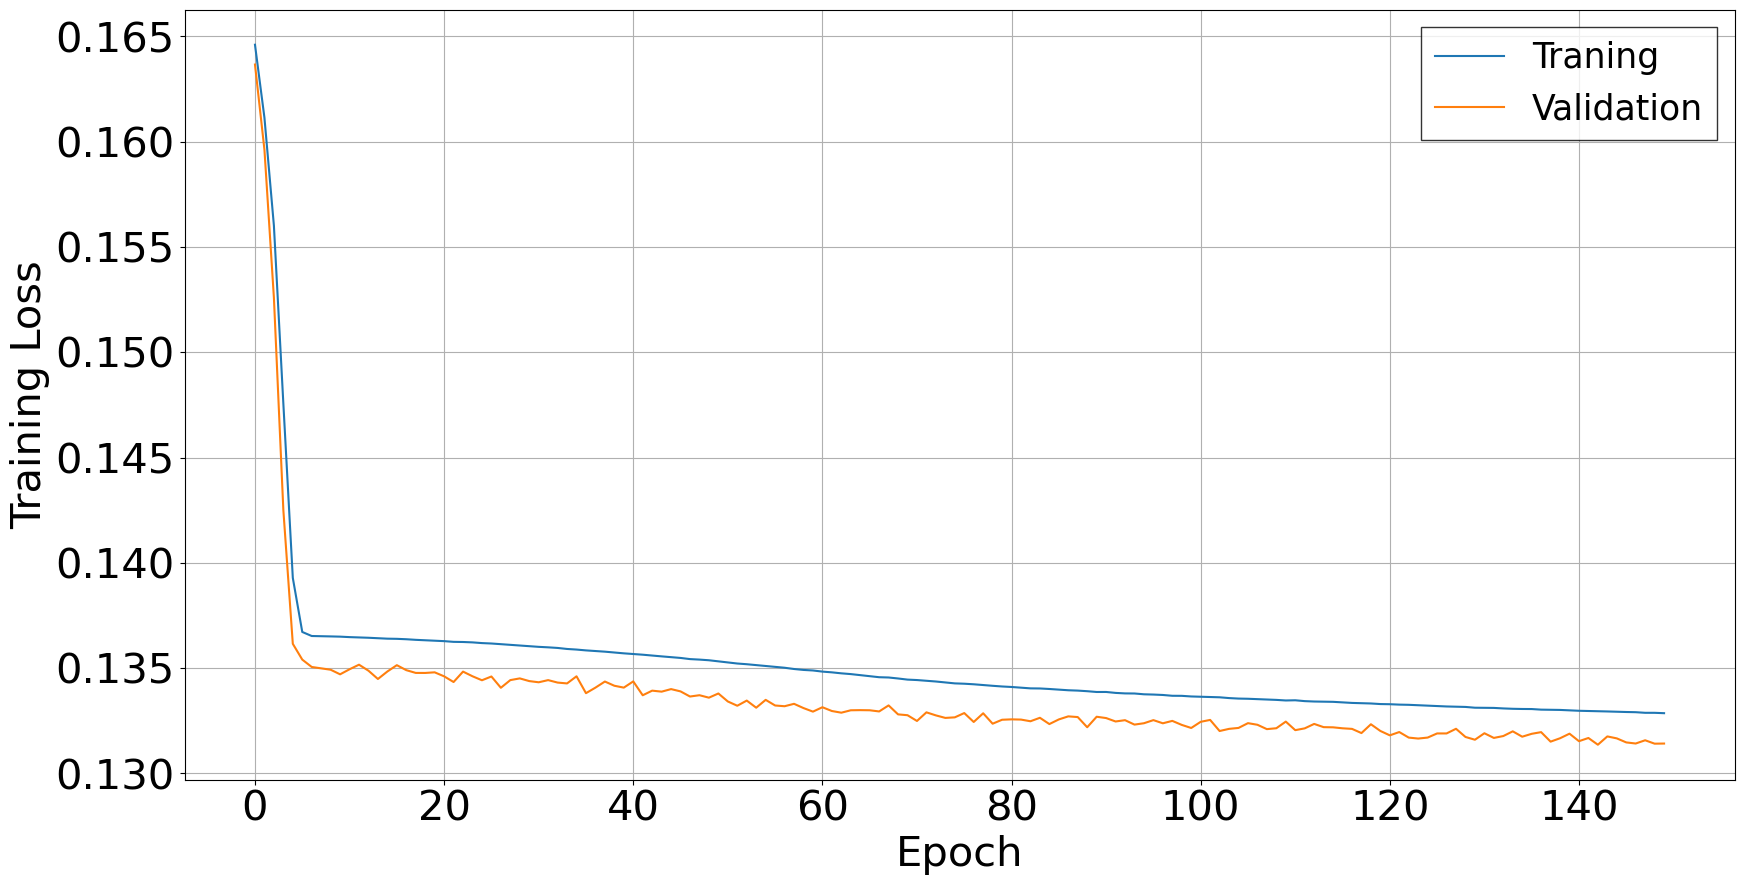

In [ ]:
plt.figure(figsize=(20,10))
ax = plt.subplot()
plt.plot(loss_graph)
plt.plot(valid_loss_graph)
ax.legend(['Traning','Validation'],fancybox=False,facecolor='white',edgecolor='black')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
#plt.savefig('GNN_train_MultiFeature_V1.png',format='png',bbox_inches='tight')

# Save/Load

### Save: Use command below, retain load one as comment

In [ ]:
torch.save(net, 'GNN_MultiFeature_V2.pt')

### Load: Use command below, retain save one as comment

In [ ]:
# net = torch.load('GNN_MultiFeature_V1.pt')
# net.eval()

# Save the NN outputs and targets of the testset

In [ ]:
out_np=np.zeros((1,6717))
tar_np=np.zeros((1,6717))
for data in test_loader:
    inputs, targets = data
    outputs = net(inputs,adj_tensor,adj_w_tensor)
    outnp=outputs.detach().cpu().numpy()
    out_np=np.vstack([out_np,outnp])
    tarnp=targets.detach().cpu().numpy()
    tar_np=np.vstack([tar_np,tarnp])

In [ ]:
out_data=out_np[1:len(out_np),:]
tar_data=tar_np[1:len(tar_np),:]

In [ ]:
out_data.max()

0.9669842720031738

In [ ]:
out_data_inv=Voltscaler.inverse_transform(out_data)
tar_data_inv=Voltscaler.inverse_transform(tar_data)

In [ ]:
out_data_inv

array([[1.0530691 , 1.05340441, 1.05340441, ..., 1.24948678, 1.35997779,
        1.02266656],
       [1.05331519, 1.05343611, 1.05343611, ..., 1.28342668, 1.37107105,
        1.02373156],
       [1.05310415, 1.05339421, 1.05339421, ..., 1.28389993, 1.3703915 ,
        1.02340081],
       ...,
       [1.05352671, 1.05347876, 1.05347876, ..., 1.3344037 , 1.37939874,
        1.02429215],
       [1.05302151, 1.05334574, 1.05334574, ..., 1.24453124, 1.34993649,
        1.02252103],
       [1.05382985, 1.05351547, 1.05351547, ..., 1.32868821, 1.38624645,
        1.02486989]])

In [ ]:
tar_data_inv

array([[1.06, 1.06, 1.06, ..., 1.04, 1.04, 1.03],
       [1.06, 1.06, 1.06, ..., 1.04, 1.04, 1.03],
       [1.06, 1.06, 1.06, ..., 1.04, 1.04, 1.03],
       ...,
       [1.06, 1.06, 1.06, ..., 1.04, 1.04, 1.03],
       [1.06, 1.06, 1.06, ..., 1.04, 1.04, 1.03],
       [1.05, 1.05, 1.05, ..., 1.04, 1.04, 1.03]])

In [ ]:
out_data_inv.shape

(1563, 6717)

In [ ]:
tar_data_inv.shape

(1563, 6717)

### Save those as numpy

In [ ]:
np.save('gen_GNN_MultiFeature_V1.npy',out_data_inv)
np.save('act_GNN_MultiFeature_V1.npy',tar_data_inv)

### Load the saved numpy

In [ ]:
# out_data_inv=np.load('gen_GNN_MultiFeature_V1.npy')
# tar_data_inv=np.load('act_GNN_MultiFeature_V1.npy')